In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/originalimages"

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load images from directory
def load_images_from_folder(folder, img_size=(100, 100)):
    X, y = [], []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            label = filename.split("-")[0]  # Extract person ID
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

# Load data
# folder_path = "originalimages"  # Update this path
X, y = load_images_from_folder(dataset_path)

# Normalize and reshape
X = X.astype("float32") / 255.0
X = X.reshape(-1, 100, 100, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

In [ ]:
from tensorflow.keras import layers, models

# CNN feature extractor
def build_cnn_feature_extractor(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())  # Keep only features, no Dense output here
    return model

cnn_model = build_cnn_feature_extractor((100, 100, 1))

# Extract CNN features
X_train_feat = cnn_model.predict(X_train)
X_test_feat = cnn_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_feat)
X_test_pca = pca.transform(X_test_feat)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = mlp_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=25,
    batch_size=32
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0050 - loss: 5.2923 - val_accuracy: 0.0375 - val_loss: 5.2468
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0241 - loss: 5.2051 - val_accuracy: 0.0464 - val_loss: 5.0329
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0546 - loss: 4.8985 - val_accuracy: 0.1107 - val_loss: 4.4713
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0848 - loss: 4.2976 - val_accuracy: 0.2696 - val_loss: 3.8115
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1517 - loss: 3.7226 - val_accuracy: 0.3768 - val_loss: 3.2141
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2160 - loss: 3.2475 - val_accuracy: 0.5000 - val_loss: 2.7635
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2773 - loss: 2.8800 - val_accuracy: 0.5661 - val_loss: 2.3669
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3309 - loss: 2.5807 - val_accuracy: 0.6446 - val_loss: 2.0689
Epo

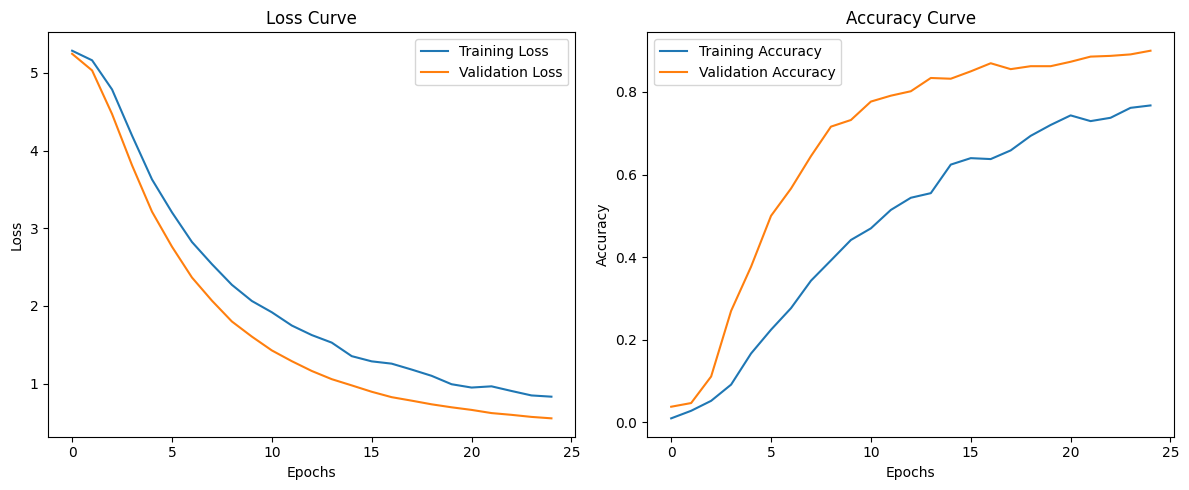

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


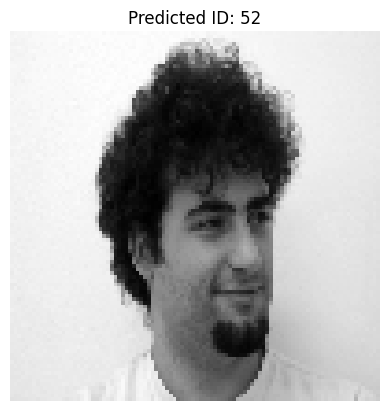

np.str_('52')

In [ ]:
def predict_face(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Image not found.")
        return
    img = cv2.resize(img, (100, 100)).astype("float32") / 255.0
    img = img.reshape(1, 100, 100, 1)

    features = cnn_model.predict(img)
    reduced = pca.transform(features)
    prediction = mlp_model.predict(reduced)
    predicted_label = np.argmax(prediction)
    identity = le.inverse_transform([predicted_label])[0]

    plt.imshow(img.reshape(100, 100), cmap='gray')
    plt.title(f"Predicted ID: {identity}")
    plt.axis('off')
    plt.show()

    return identity

# Example usage
predict_face("/content/drive/MyDrive/Datasets/originalimages/52-08.jpg")
